In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

/home/mffang/workspace/Poisson-regression
2023.05.01.10


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import copy
import time

In [71]:
%cd simulations/simulation_results
results_dir = 'model_selection/'

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

/home/mffang/workspace/Poisson-regression/simulations/simulation_results


In [17]:
from RADOM.models.two_species_ss import get_Y

def simulate_data(topo, tau, n, p, t_samples=None, loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, rd_var=0, logu_mu=0, logu_sd=0, random_seed=2023, plot=False):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    true_t = []
    if t_samples is None:
        t_samples=np.random.uniform(tau[0],tau[-1],size=100*n)
    
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.random.lognormal(loga_mu, loga_sd,size=p)
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.random.choice(t_samples,size=n)
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)
    
    if logu_sd != 0:
        Ubias = np.random.lognormal(logu_mu,logu_sd,p)
        Y[:,:,0] *= Ubias[None,:]
    else:
        Ubias = 1
        
    if rd_var != 0:
        read_depth = np.random.gamma(1/rd_var,1/rd_var,n*L)
        rd = read_depth/read_depth.mean()
        X = np.random.poisson(rd[:,None,None]*Y)
    else:
        rd = np.ones(n*L)
        X = np.random.poisson(Y)
        
    if plot:
        fig, ax = plt.subplots(1,5,figsize=(30,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
        ax[2].hist(rd,bins=100)
        ax[2].set_title("read depth")
        ax[3].hist(Ubias,bins=100)
        ax[3].set_title("U/S bias")
        ax[4].hist(true_t,bins=100)
        ax[4].set_title("t")
    
    return theta, true_t, Y, X, rd, Ubias

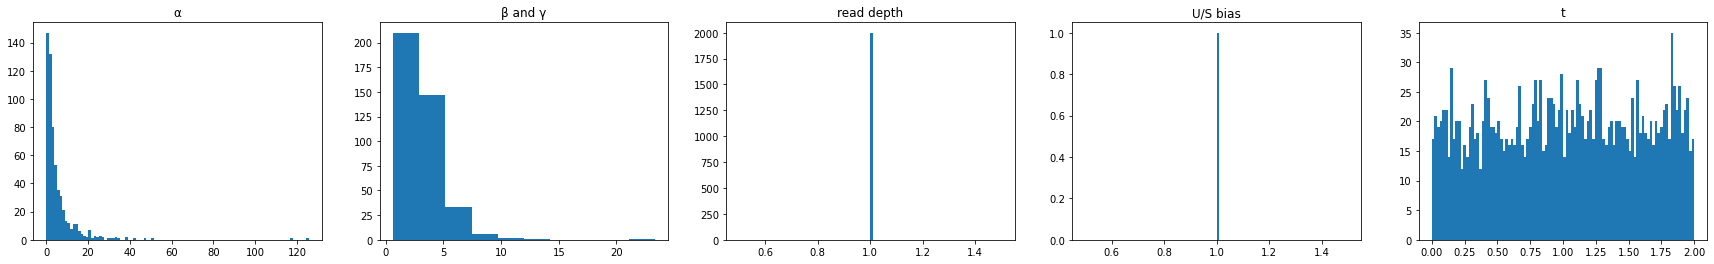

In [7]:
#%% generate data
topo=np.array([[0,1,2]])
tau=(0,1,2)
#%% generate data
true_theta, true_t, Y, X, rd, Ubias = simulate_data(topo,tau,n=2000,p=200,rd_var=0,random_seed=2023)

In [8]:
params={"r":rd,"lambda_a":0}
traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=1)
traj = traj.fit(X, warm_start=True, theta=true_theta.copy(), params=params, n_init=1, perm_theta=False, parallel=True, epoch=3, n_threads=10)

fitting with warm start


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


In [9]:
AIC = traj.compute_AIC(X,standard=False)

In [10]:
BIC = traj.compute_BIC(X,standard=False)

ELBO_x: $\log(x|\hat{\theta}(x))$

ELBO_true: $\log(x|\theta_0)$

ELBO_y: $\log(y|\hat{\theta}(x))$

In [69]:
ELBO_y = []
ELBO_x = []
ELBO_true = []
trajs = []
for seed in tqdm(range(10)):
    true_theta, true_t, Y, X, rd, Ubias = simulate_data(topo,tau,n=2000,p=200,rd_var=0,random_seed=seed)
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=True, theta=true_theta.copy(), params=params, epoch=0)
    ELBO_true.append(traj.compute_lower_bound(X))
    traj = traj.fit(X, warm_start=False, params=params, parallel=True, n_init=10, epoch=100, n_threads=10)
    ELBO_x.append(traj.compute_lower_bound(X))
    elbo_y = []
    for k in range(100):
        X_Y = np.random.poisson(Y)
        elbo_y.append(traj.compute_lower_bound(X_Y))
    ELBO_y.append(np.mean(elbo_y))

  0%|          | 0/10 [00:29<?, ?it/s]


KeyboardInterrupt: 

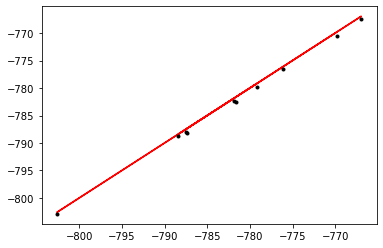

In [35]:
plt.plot(ELBO_x,ELBO_x,'r-')
plt.plot(ELBO_x,ELBO_y,'k.')

In [40]:
1001/2000

0.5005

In [36]:
np.mean(ELBO_x)-np.mean(ELBO_y)

0.5370769953271974

In [37]:
np.mean(ELBO_x)-np.mean(ELBO_true)

0.2520559164579481

In [45]:
ELBO_y = []
ELBO_x = []
ELBO_true = []
for seed in tqdm(range(100)):
    true_theta, true_t, Y, X, rd, Ubias = simulate_data(topo,tau,n=2000,p=200,rd_var=0,random_seed=seed)
    true_theta_ = np.zeros((true_theta.shape[0],true_theta.shape[1]+1))
    true_theta_[:,:-3]=true_theta[:,:-2]
    true_theta_[:,-2:]=true_theta[:,-2:]
    true_theta_[:,-3]=true_theta[:,0]*true_theta[:,-2]/true_theta[:,-1]
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=True, theta=true_theta_.copy(), params=params, epoch=0)
    ELBO_true.append(traj.compute_lower_bound(X))
    traj = traj.fit(X, warm_start=True, theta=true_theta_.copy(), params=params, parallel=True, epoch=3, n_threads=4)
    ELBO_x.append(traj.compute_lower_bound(X))
    elbo_y = []
    for k in range(100):
        X_Y = np.random.poisson(Y)
        elbo_y.append(traj.compute_lower_bound(X_Y))
    ELBO_y.append(np.mean(elbo_y))

100%|██████████| 100/100 [23:02<00:00, 13.82s/it]


In [46]:
1201/2000

0.6005

In [47]:
np.mean(ELBO_true)-np.mean(ELBO_y)

0.8077442719452392

In [48]:
np.mean(ELBO_x)-np.mean(ELBO_true)

-0.23434689477596748

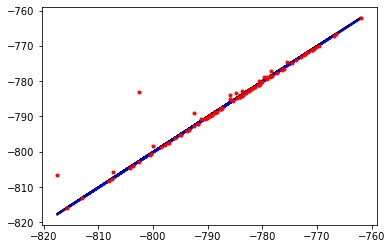

In [60]:
plt.plot(ELBO_x,ELBO_x,'k-')
plt.plot(ELBO_x,np.array(ELBO_x)-600/2000,'b-')
plt.plot(ELBO_x,ELBO_true,'r.')

In [61]:
topo=np.array([[0,1,2]])
tau=(0,1,2)
topo_=np.array([[0,1,2,3]])
tau_=(0,1,1.5,2)
ELBO_y = []
ELBO_x = []
ELBO_true = []
for seed in tqdm(range(100)):
    true_theta, true_t, Y, X, rd, Ubias = simulate_data(topo,tau,n=2000,p=200,rd_var=0,random_seed=seed)
    true_theta_ = np.zeros((true_theta.shape[0],true_theta.shape[1]+1))
    true_theta_[:,:-3]=true_theta[:,:-2]
    true_theta_[:,-2:]=true_theta[:,-2:]
    true_theta_[:,-3]=true_theta[:,-3]
    traj = Trajectory(topo_, tau_,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=True, theta=true_theta_.copy(), params=params, epoch=0)
    ELBO_true.append(traj.compute_lower_bound(X))
    traj = traj.fit(X, warm_start=True, theta=true_theta_.copy(), params=params, parallel=True, epoch=3, n_threads=4)
    ELBO_x.append(traj.compute_lower_bound(X))
    elbo_y = []
    for k in range(100):
        X_Y = np.random.poisson(Y)
        elbo_y.append(traj.compute_lower_bound(X_Y))
    ELBO_y.append(np.mean(elbo_y))

100%|██████████| 100/100 [24:26<00:00, 14.66s/it]


In [62]:
np.mean(ELBO_true)-np.mean(ELBO_y)

0.48986246586423476

In [63]:
np.mean(ELBO_x)-np.mean(ELBO_true)

0.08293598735167507

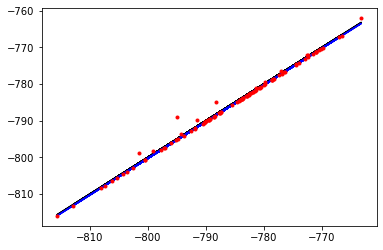

In [64]:
plt.plot(ELBO_x,ELBO_x,'k-')
plt.plot(ELBO_x,np.array(ELBO_x)-600/2000,'b-')
plt.plot(ELBO_x,ELBO_true,'r.')

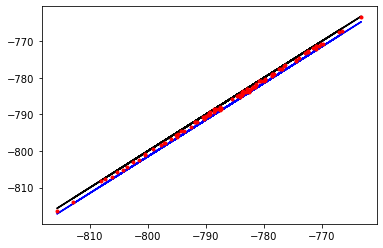

In [68]:
plt.plot(ELBO_x,ELBO_x,'k-')
plt.plot(ELBO_x,np.array(ELBO_x)-1201/(2000-1201-1),'b-')
plt.plot(ELBO_x,ELBO_y,'r.')

In [75]:
true_topo = np.array([[0,1,2]])
true_tau=(0,0.75,2)

topo_1 = np.array([[0,1,2]])
tau_1=(0,1.0,2)

topo_2 = np.array([[0,1,2,3]])
tau_2 = (0,0.1,1.5,2)
           
def fit_model_wrapper(X, Y, true_t, theta, params):
    traj0 = Trajectory(topo_1, tau_1, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,params=params,fit_tau=True,n_init=10,epoch=100,parallel=False,n_threads=1)
    traj0.true_t = true_t
    traj0.true_topo = true_topo
    traj0.true_tau = true_tau
    traj0.true_theta = theta
    traj0.Y = Y

    traj1 = Trajectory(topo_1, tau_1, model="two_species", verbose=0)
    traj1 = traj1.fit(X,params=params,fit_tau=True,n_init=10,epoch=100,parallel=False,n_threads=1)
    traj1.true_topo = true_topo
    traj1.true_tau = true_tau
    traj1.true_t = true_t
    traj1.true_theta = theta
    traj1.Y = Y

    traj2 = Trajectory(topo_2, tau_2, model="two_species_ss", verbose=0)
    traj2 = traj2.fit(X,params=params,fit_tau=True,n_init=10,epoch=100,parallel=False,n_threads=1)
    traj2.true_t = true_t
    traj2.true_topo = true_topo
    traj2.true_tau = true_tau
    traj2.true_theta = theta
    traj2.Y = Y

    return (traj0,traj1,traj2)

from multiprocessing import Pool

def vary_model_topo1(n=2000, p=200, t_samples=None, K=20, n_init=10, epoch=100, m=100, cores=15, loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, rd_var=0.25):        
    L=len(true_topo)
    n_states=len(set(true_topo.flatten()))
    if t_samples is None:
        t_samples=np.random.uniform(tau[0],tau[-1],size=100*n)

    Input_args = []
    for k in range(K):
        np.random.seed(k)                
        theta=np.zeros((p,n_states+2))
        for j in range(n_states):
            theta[:,j]=np.random.lognormal(loga_mu, loga_sd,size=p)
        theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
        theta[:,:n_states]/=theta[:,-2,None]

        true_t = []
        Y = np.zeros((n*L,p,2)) 
        for l in range(L):
            t = np.random.choice(t_samples,n)
            theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
            Y[l*n:(l+1)*n] = get_Y(theta_l,t,true_tau) # m*p*2
            true_t = np.append(true_t,t)

        if rd_var > 0:
            read_depth = np.random.gamma(1/rd_var,rd_var,n*L)
            rd = read_depth/read_depth.mean()
        else:
            rd = np.ones(n*L)

        X = np.random.poisson(rd[:,None,None]*Y)      

        params={'r':rd}
        Input_args.append((X, Y, true_t, theta, params))
    
    with Pool(cores) as pool:      
        results = pool.starmap(fit_model_wrapper, Input_args, chunksize=1)
    
    return results


In [ ]:
results = vary_model_topo1(n=2000, p=200, t_samples=None, K=100,\
                           n_init=10, epoch=100, m=100, cores=50,\
                           loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, rd_var=0)
with open(results_dir+'topo_1_2000.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)